<a href="https://colab.research.google.com/github/Dms-zi/DeepLearning_Pytorch/blob/main/Pytorch_FristStep/CNN_Regression_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
from torch import nn, optim
import tqdm

# Dataset

In [2]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar -zxvf lfw-deepfunneled.tgz
!mkdir lfw-deepfunneled/train
!mv lfw-deepfunneled/[A-W]* lfw-deepfunneled/train
!mkdir lfw-deepfunneled/test
!mv lfw-deepfunneled/[X-Z]* lfw-deepfunneled/test

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0013.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0014.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0015.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0016.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0017.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0018.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0019.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0020.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0021.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg
lfw-deepfunneled/Luiz_Inacio

In [8]:
class DownSizedPairImageFolder(ImageFolder):
    def __init__(self,root,transform=None,
                large_size=128, small_size=32, **kwds):
        super().__init__(root,transform=transform, **kwds)
        self.large_resizer=transforms.Resize(large_size)
        self.small_resizer=transforms.Resize(small_size)
        
    def __getitem__(self,index):
        path,_=self.imgs[index]
        img=self.loader(path)
        
        # 읽은 이미지 128*128, 32*32 픽셀로 resize
        large_img=self.large_resizer(img)
        small_img=self.small_resizer(img)
        
        # 기타 변환 적용
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
            
        #32픽셀 이미지 128픽셀 이미지 변환
        return small_img, large_img

# DataLoader

In [9]:
train_data=DownSizedPairImageFolder(
    "/content/lfw-deepfunneled/train",
    transform=transforms.ToTensor())
test_data=DownSizedPairImageFolder(
    "/content/lfw-deepfunneled/test",
    transform=transforms.ToTensor())

batch_size=32
train_loader=DataLoader(train_data, batch_size= batch_size, shuffle=True, num_workers=4)
test_loader=DataLoader(test_data, batch_size= batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
net=nn.Sequential(
    nn.Conv2d(3,256,4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),

    nn.Conv2d(256,512,4,stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(512),

    nn.ConvTranspose2d(512,256,4,stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),

    nn.ConvTranspose2d(256,128,4,stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),

    nn.ConvTranspose2d(128,64,4,stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64,3,4,stride=2, padding=1))

In [13]:
import math
def psnr(mse,max_v=1.0):
  return 10*math.log10(max_v**2/mse)

#평가 헬퍼 함수
def eval_net(net,data_loader,device="cpu"):
  # dropout 및 batchnorm 무효화
  net.eval()
  ys=[]
  ypreds=[]
  for x,y in data_loader:
    x=x.to(device)
    y=y.to(device)
    with torch.no_grad():
      y_pred=net(x)
    ys.append(y)
    ypreds.append(y_pred)
  
  ys=torch.cat(ys)
  ypreds=torch.cat(ypreds)

  #MSE
  score=nn.functional.mse_loss(ypreds,ys).item()
  return score

def train_net(net,train_loader,test_loader, optimizer_cls=optim.Adam,loss_fn=nn.MSELoss(), n_iter=10, device="cpu"):
    train_losses=[]
    train_acc=[]
    val_acc=[]
    optim=optimizer_cls(net.parameters())
        
    for e in range(n_iter):
        running_loss=0.0
        #신경망을 훈련 모드로 설정
        
        net.train()
        n=0
        n_acc=0
        
        for i,(xx,yy) in tqdm.tqdm(enumerate(train_loader),
                                  total=len(train_loader)):
                xx=xx.to(device)
                yy=yy.to(device)

                h=net(xx)
                loss=loss_fn(h,yy)
                optim.zero_grad()
                loss.backward()
                optim.step()

                running_loss += loss.item()
                n+=len(xx)
                _,y_pred=h.max(1)
                
                
                #훈련 데이터의 예측 정확도
        train_losses.append(running_loss/i)
        train_acc.append(n_acc/n)
            
                #검증 데이터의 예측 정확도
        val_acc.append(eval_net(net,test_loader,device))
                #에포크 결과 표시
        print(e,train_losses[-1], train_acc[-1], val_acc[-1],flush=True)



In [14]:
net.to("cuda:0")
train_net(net,train_loader,test_loader,device="cuda:0")

100%|██████████| 409/409 [00:30<00:00, 13.25it/s]


0 0.031439261243897766 0.0 0.005109784658998251


100%|██████████| 409/409 [00:29<00:00, 13.97it/s]


1 0.0047165273212800354 0.0 0.004000573884695768


100%|██████████| 409/409 [00:29<00:00, 13.90it/s]


2 0.0037848376280938587 0.0 0.003306229365989566


100%|██████████| 409/409 [00:29<00:00, 13.94it/s]


3 0.0033408302645993363 0.0 0.002918511861935258


100%|██████████| 409/409 [00:30<00:00, 13.33it/s]


4 0.0031052058877642542 0.0 0.0030112741515040398


100%|██████████| 409/409 [00:29<00:00, 14.06it/s]


5 0.0029538305642941563 0.0 0.002505191368982196


100%|██████████| 409/409 [00:29<00:00, 14.08it/s]


6 0.0029444992713465847 0.0 0.002611103467643261


100%|██████████| 409/409 [00:29<00:00, 13.95it/s]


7 0.002817751006303154 0.0 0.002426480408757925


100%|██████████| 409/409 [00:30<00:00, 13.44it/s]


8 0.0026850668504016986 0.0 0.0025996724143624306


100%|██████████| 409/409 [00:29<00:00, 14.02it/s]


9 0.0025762727777427974 0.0 0.002384164137765765


In [16]:
from torchvision.utils import save_image

# 테스트 데이터로부터 랜덤으로 4개씩 출력
random_test_loader=DataLoader(test_data,batch_size=4,shuffle=True)
#dataloader를 이터레이터로 변환해 4개의 예로 추출
it=iter(random_test_loader)
x,y=next(it)

#bilinear 확대
bl_recon=torch.nn.functional.upsample(x,128,mode="bilinear",align_corners=True)
#CNN으로 확대
yp=net(x.to("cuda:0")).to("cpu")

#torch,cat으로 원본, bilinearm cnn 이미지 결합, save_image로 결합한 이미지 출력
save_image(torch.cat([y,bl_recon,yp],0),'cnn_upsacle.jpg',nrow=4)



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


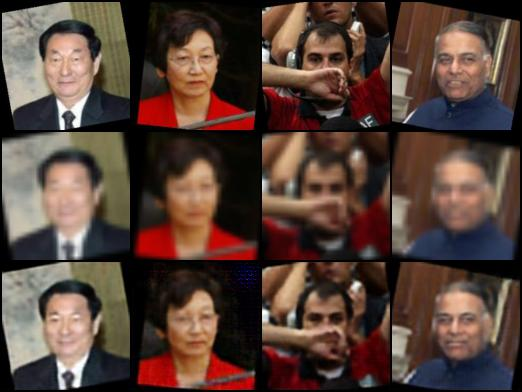

In [18]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('cnn_upsacle.jpg'))

In [ ]:
A